In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report

import cv2 as cv
import os

In [2]:
df = pd.read_csv('median_hsv_full.csv')
df

,n_img,n_row,n_col,tile_type,h,s,v
0,0,4,4,0,26.0,246.0,198.0
1,0,0,0,1,43.0,215.0,156.0
2,0,1,0,1,44.0,212.0,156.0
3,0,1,4,1,42.0,216.0,151.0
4,0,2,0,1,41.0,209.0,154.0
...,...,...,...,...,...,...,...
1845,73,4,1,4,105.0,248.0,152.0
1846,73,4,2,4,105.0,250.0,160.0
1847,73,4,3,4,105.0,248.0,154.0
1848,73,4,4,4,106.0,232.0,138.0


In [3]:
validation_images = [0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 54, 55, 56, 64, 65, 66]
df = df.rename(columns={'h': 'hue', 's': 'saturation', 'v': 'value'})

train = df[df['n_img'].isin(validation_images)]
test = df[~df['n_img'].isin(validation_images)]

train = train.drop(['n_img', 'n_row', 'n_col'], axis=1)
test = test.drop(['n_img', 'n_row', 'n_col'], axis=1)

X_train = train.drop('tile_type', axis=1)
X_test = test.drop('tile_type', axis=1)
y_train = train['tile_type'].astype('category')
y_test = test['tile_type'].astype('category')

In [4]:
def get_tiles(image):
    tiles = []
    for y in range(5):
        tiles.append([])
        for x in range(5):
            tiles[-1].append(image[y * 100 : (y + 1) * 100, x * 100 : (x + 1) * 100])
    return tiles

In [5]:
def get_terrain(hue, saturation, value):
    if 22 < hue < 30 and 225 < saturation < 256 and 104 < value < 210:
        return 0
    if 28 < hue < 61 and 73 < saturation < 224 and 32 < value < 70:
        return 2
    if 100 < hue < 110 and 210 < saturation < 256 and 107 < value < 195:
        return 4
    if 33 < hue < 49 and 160 < saturation < 256 and 72 < value < 170:
        return 1
    if 17 < hue < 28 and 34 < saturation < 180 and 72 < value < 148:
        return 3
    if 19 < hue < 28 and 38 < saturation < 140 and 23 < value < 70:
        return 5
    if 16 < hue < 39 and 40 < saturation < 150 and 52 < value < 150:
        return 6
    return 7

In [6]:
def predict(X):
    pred = np.zeros(len(X))


    for i in range(len(X)):
        pred[i] = get_terrain(*X.iloc[i])

    return pred

In [7]:
y_pred = predict(X_test)
y_pred

array([0., 0., 0., ..., 4., 4., 3.])

In [8]:

tile_types_str = np.array([
    "Wheat Field",
    "Grassland",
    "Forest",
    "Swamp",
    "Lake",
    "Mine",
    "Castle",
    "Table",
])

y_test_df = pd.DataFrame(y_test).astype('int').apply(lambda x: tile_types_str[x])
y_pred_df = pd.DataFrame(y_pred).astype('int').apply(lambda x: tile_types_str[x])

# print(y_test_df)
# print(y_pred_df)

# y_test = np.choose(tile_types_str, y_test)
# y_pred = np.choose(tile_types_str, y_pred)

report = classification_report(y_test_df, y_pred_df, output_dict=True)

report_df = pd.DataFrame(report).transpose()

report_percentages = report_df.drop(['f1-score', 'support'], axis=1).mul(100).round(1).astype(str) + '%'
report_support = report_df['support']

report_percentages['support'] = report_support.astype('int')
report_percentages


NameError: name 'classification_report' is not defined

In [26]:
tile_classes = df['tile_type'].unique()
confusion_matrix = np.zeros((len(tile_classes), len(tile_classes)))

for i in range(len(tile_classes)):
    for j in range(len(tile_classes)):
        confusion_matrix[j, i] = np.sum(y_pred[y_test == i] == j)

# pd.DataFrame(confusion_matrix)
# sum(y == 6)

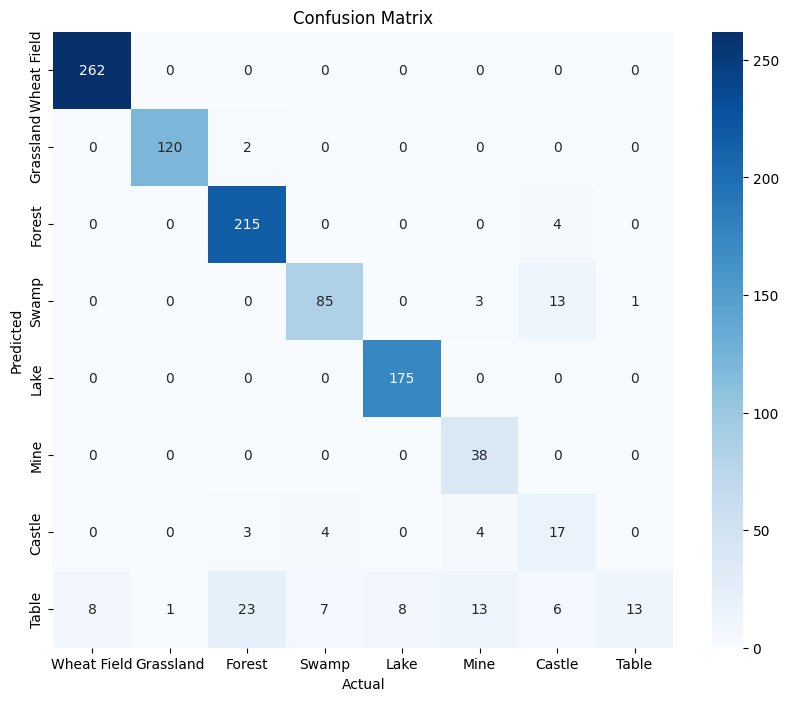

In [27]:
# Create a figure and axis
plt.figure(figsize=(10, 8))

tile_classes_str = [
    "Wheat Field",
    "Grassland",
    "Forest",
    "Swamp",
    "Lake",
    "Mine",
    "Castle",
    "Table",
]

# Create the heatmap using Seaborn
sns.heatmap(confusion_matrix.astype(np.int16), annot=True, fmt='d', cmap='Blues', 
            xticklabels=tile_classes_str,  # Replace with your class labels
            yticklabels=tile_classes_str)  # Replace with your class labels

# Set labels and title
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

In [28]:
print(f'med i cm: {confusion_matrix.sum()}')
print(f'ikke med i cm: {len(y_pred) - confusion_matrix.sum()}')

print(f'andel ikke med i cm: {(len(y_pred) - confusion_matrix.sum()) / len(y_pred):0.01%}')


med i cm: 1025.0
ikke med i cm: 0.0
andel ikke med i cm: 0.0%
